In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import glob
import scipy.ndimage
import matplotlib.pyplot as plt
import ipyvolume


import SimpleITK as sitk
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '/media/mike/tera/data/databowl/kgsamples/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [2]:
luna_path =  '/media/mike/tera/data/databowl/luna/'
luna_subset_path = '/media/mike/tera/data/databowl/luna/subset0/'
output_path = luna_path + 'output/'
file_list=glob.glob(luna_subset_path+"*.mhd")

#####################
#
# Helper function to get rows in data frame associated 
# with each file
def get_origin(filepath):
    itk_img = sitk.ReadImage(filepath)
    origin = np.array(itk_img.GetOrigin())
    return origin

def coord_to_ary_idx(coord, origin):
    coord = np.array(coord)
    origin = np.array(origin)
    x, y, z = coord - origin
    absidx = x, y, z # i have no idea why these things use such crazy indexing. but this will match the numpy slicing dims
    print(absidx)
    return list(map(int, absidx))

def get_fiducial_slice(coord, edgelen=48):
    ''' '''
    x, y, z = map(int, coord)
    m = edgelen // 2
    print(x+m, x-m, y+m, y-m, z+m, z-m)
    return (x-m, x+m, y-m, y+m, z-m, z+m)
    
def draw_fiducial_cube(ary_shape, coord, edgelen=48, dtype='int16'):
    
    ary = np.ones(ary_shape, dtype=dtype)
    x0, x1, y0, y1, z0, z1 = get_fiducial_slice(coord, edgelen=edgelen)
    ary[:z0] = 0
    ary[z1:] = 0
    ary[:,:y0] = 0
    ary[:,y1:] = 0
    ary[:,:,:x0] = 0
    ary[:,:,x1:] = 0
    print(np.sum(ary))
    return ary
 
def get_filename(case):
    global file_list # gross, yet effective...
    for f in file_list:
        if case in f:
            return(f)
        
def strip_uid(path):
    fname = os.path.basename(path)
    return fname.strip('.mhd.npy')
#
# The locations of the nodes
df_node = pd.read_csv(luna_path+"annotations.csv")
df_node["file"] = df_node["seriesuid"].apply(get_filename)
df_node = df_node.dropna()

In [3]:
dfs = df_node.sort_values(by='diameter_mm', ascending=0)
dfs.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
1011,1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803...,60.775061,74.123970,-214.782347,25.233202,/media/mike/tera/data/databowl/luna/subset0/1....
1141,1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...,109.116637,48.589511,-120.892058,21.583112,/media/mike/tera/data/databowl/luna/subset0/1....
1084,1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840...,56.393154,67.680087,-64.674453,19.653877,/media/mike/tera/data/databowl/luna/subset0/1....
420,1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116...,-83.158083,-21.678997,-97.004376,18.783233,/media/mike/tera/data/databowl/luna/subset0/1....
336,1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205...,94.635117,-17.372059,-204.396127,17.753232,/media/mike/tera/data/databowl/luna/subset0/1....


In [4]:
print(len(df_node))
resamp_path = '/media/mike/tera/data/databowl/resampled_images/'
resamps = glob.glob(resamp_path + '*.mhd.npy')
print(len(resamps))

112
89


In [5]:
uids = [strip_uid(path) for path in resamps]
# sum([uid in uids for uid in dfs['seriesuid'].values]) # check if the data is there
# sum([dfs['seriesuid'].values[0] in path for path in resamps])

In [6]:
biggest = dfs.iloc[0]

In [232]:
def padcrop_vol(vol, newshape=[360, 360, 360], padtype='symmetric', value='origin'):
    vol2 = np.array(vol)
    shape = vol.shape
    z, y, x = shape
    mids = [d // 2 for d in shape]
    if value == 'origin':
        constant_values = vol[0,0,0]
        print('Origin: ', constant_values)
    else:
        try:
            constant_values = float(value)
        except ValueError:
            raise ValueError('Invalid parameter "value" specified. Cannot coerce to symbol type or float')
        
    
    for dim in range(3):
        if shape[dim] < newshape[dim]:
            pad_amt = (newshape[dim] - shape[dim]) // 2
            parity = (shape[dim] & 1) ^ (newshape[dim] & 1)
            if padtype[:3] == 'sym':
                pad_tup = (pad_amt, pad_amt + parity) # 
            elif padtype[:3] == 'ori':
                pad_tup = (0, pad_amt + pad_amt + parity) 
            else:
                raise ValueError('Must specify valid padding mode: {"symmetric", "origin"}')
            pad_list = [(0,0), (0,0), (0,0)]
            pad_list[dim] = pad_tup
            vol2 = np.pad(vol2, pad_list, mode='constant', constant_values=constant_values)
        if shape[dim] > newshape[dim]:
            slc_amt = (shape[dim] - newshape[dim]) // 2
            parity = (shape[dim] & 1) ^ (newshape[dim] & 1)
            slc_tup = (slc_amt, shape[dim] - slc_amt - parity) # 
            null1, vol2, null2 = np.split(vol2, slc_tup, dim)

    return vol2

In [224]:
def subsect(a, edge_length=48, stride=0.5, serialize=True, verbose=False):
    nx, ny, nz = a.shape
    new_idx = [(nn // edge_length) if (nn%edge_length)==0 else (nn// edge_length)+1 for nn in a.shape ] # deal with the edge case of evenly divisible dim length
    if verbose: 
        print('New indicies: {}'.format(new_idx))
    new_shape = [edge_length*idx for idx in new_idx]
    a2 = padcrop_vol(a, newshape=new_shape)
    b = np.array(np.split(a2, new_idx[0], axis=0))
    b = np.array(np.split(b, new_idx[1], axis=2))
    b = np.array(np.split(b, new_idx[2], axis=4))
    if serialize:
        b = np.reshape(b, (-1, edge_length, edge_length, edge_length))

    return b, new_idx

In [98]:
def cube(a):
    n = a.shape[0]
    d = np.around(n**(1/3))
    d = int(d)
    assert d**3 == n, 'Dimensions are not an even cube!'
    return a.reshape((d,d,d))

In [223]:
# Some general purpose Numpy tensor indexing wizardry
def coord_to_ravel_idx3(shape, xyz):
    n0, n1, n2 = shape
    x, y, z = xyz
    idx = z*n2*n1 + y*n2 + x
    return idx

def coord_to_ravel_idx(shape, coord):
    assert len(shape) == len(coord), 'Must have matching dimension'
    N = len(shape)
    idx = coord[0]
    for i in range(1, N):
        idx += coord[i]*np.prod(shape[N-i:])
        print(i, coord[i], shape[N-i:])
    
    return idx

def ravel_idx_to_coord(shape, idx):
    N = len(shape)
    coefs = []
    coords = []
    r = idx
    for i in range(N-1, 0, -1):
        coef = shape[N-i:]
        coefs.append(coef)
        q, r = divmod(r, np.prod(coef))
        coords.append(q)
        print(q,r)
    coords.append(r)
    coords.reverse()
    
    return coefs, coords


In [145]:
# mask = np.ones(pix_resampled.shape)
# mz, my, mx = pix_resampled.shape
# print(mz, my, mx)
# mask[140:] = 0
# mask[:110] = 0
# mask[:,:50] = 0
# mask[:,my-50:] = 0
# mask[:,:,mx-50:] = 0
# mask[:,:,:50] = 0
# mask2 = np.less(pix_resampled,1267)
# mask3 = np.greater(pix_resampled,400)

# ipyvolume.quickvolshow(pix_resampled*mask*mask3, width=1000, height=1000, level=[.26, .3, .85], level_width=[.5, .1, .05])

In [146]:
ary = np.load(resamp_path + biggest['seriesuid'] + '.mhd.npy')
print(ary.shape, np.amin(ary), np.amax(ary), np.mean(ary))

(368, 360, 360) -2472 3652 -814.075541801


In [147]:
biggest

seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803...
coordX                                                   60.7751
coordY                                                    74.124
coordZ                                                  -214.782
diameter_mm                                              25.2332
file           /media/mike/tera/data/databowl/luna/subset0/1....
Name: 1011, dtype: object

In [148]:
nx, ny, nz = biggest['coordX'], biggest['coordY'], biggest['coordZ']
nx, ny, nz

(60.775060529999998, 74.123969599999995, -214.78234660000001)

In [149]:
origin = get_origin(luna_subset_path + biggest['seriesuid'] + '.mhd')
origin

array([-182.100006, -195.600006, -382.5     ])

In [150]:
absidx = coord_to_ary_idx((nx, ny, nz), origin)
absidx

(242.87506653, 269.72397560000002, 167.71765339999999)


[242, 269, 167]

In [151]:
fid = draw_fiducial_cube(ary.shape, (nx,ny,nz), 20)
nporig = draw_fiducial_cube(ary.shape, (25,25,25))
tumor = draw_fiducial_cube(ary.shape, absidx, 30)

70 50 84 64 -204 -224
8000
49 1 49 1 49 1
110592
257 227 284 254 182 152
27000


In [152]:
# vol = np.array(ary, dtype=np.int16) 
# vol +=  5000*nporig + 5000*fid +5000*tumor
# # vol = np.array(vol, dtype=np.int16)
# print(type(vol))
# print(vol.shape, vol.dtype)

In [153]:
# plt.figure(figsize=(8,8))
# plt.imshow(vol[absidx[2]])

In [226]:
ary.shape

(368, 360, 360)

In [228]:
8*48

384

In [229]:
volist, new_idx = subsect(ary, 48, verbose=True, serialize=False)
volist.shape

New indicies: [8, 8, 8]
Origin:  -2048


(8, 8, 8, 48, 48, 48)

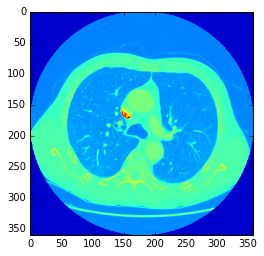

In [158]:
plt.imshow((ary+tumor)[absidx[0]])

In [160]:
vol = np.array(ary, dtype=np.int16) 
vol +=  5000*tumor

print(vol.shape, vol.dtype)

(368, 360, 360) int16


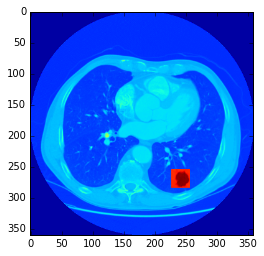

In [162]:
plt.imshow(vol[absidx[2]])

In [164]:
# The point we are trying to hit in xyz notation is: 
print(absidx)

[242, 269, 167]


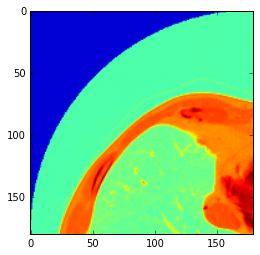

In [21]:
plt.imshow(volist[0][120])

In [22]:
vv = volist[7]
ipyvolume.quickvolshow(vv, width=500, height=500, level_width=[.1, .1, .05], level=[.3, .46, .55], opacity=[.01, .05, .05], )


/home/mike/ve/ml/lib/python3.5/site-packages/ipyvolume/serialize.py:21: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [23]:
list(range(0,600, 48))

[0, 48, 96, 144, 192, 240, 288, 336, 384, 432, 480, 528, 576]

In [24]:


a = np.arange(12**3)
a = cube(a)
print(a.shape)
a

(12, 12, 12)


array([[[   0,    1,    2, ...,    9,   10,   11],
        [  12,   13,   14, ...,   21,   22,   23],
        [  24,   25,   26, ...,   33,   34,   35],
        ..., 
        [ 108,  109,  110, ...,  117,  118,  119],
        [ 120,  121,  122, ...,  129,  130,  131],
        [ 132,  133,  134, ...,  141,  142,  143]],

       [[ 144,  145,  146, ...,  153,  154,  155],
        [ 156,  157,  158, ...,  165,  166,  167],
        [ 168,  169,  170, ...,  177,  178,  179],
        ..., 
        [ 252,  253,  254, ...,  261,  262,  263],
        [ 264,  265,  266, ...,  273,  274,  275],
        [ 276,  277,  278, ...,  285,  286,  287]],

       [[ 288,  289,  290, ...,  297,  298,  299],
        [ 300,  301,  302, ...,  309,  310,  311],
        [ 312,  313,  314, ...,  321,  322,  323],
        ..., 
        [ 396,  397,  398, ...,  405,  406,  407],
        [ 408,  409,  410, ...,  417,  418,  419],
        [ 420,  421,  422, ...,  429,  430,  431]],

       ..., 
       [[1296, 1297, 

In [25]:
a[:2, :2, :2]

array([[[  0,   1],
        [ 12,  13]],

       [[144, 145],
        [156, 157]]])

In [26]:
b = np.array(np.split(a, 6, axis=0))
# b = np.array(np.split(b, 6, axis=2))
# b = np.array(np.split(b, 6, axis=4))
print(b.shape)
# b[0][0][0]
b[0]

(6, 2, 12, 12)


array([[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11],
        [ 12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23],
        [ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35],
        [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47],
        [ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
        [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71],
        [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83],
        [ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95],
        [ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107],
        [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
        [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131],
        [132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]],

       [[144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155],
        [156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
        [168, 169,

In [27]:
b[-1][-1][-1]

array([1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726,
       1727])

In [28]:
c = b.reshape((-1, 2, 2, 2))
c[0]

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

In [29]:
c[-1]

array([[[1720, 1721],
        [1722, 1723]],

       [[1724, 1725],
        [1726, 1727]]])

In [30]:
a = np.arange(3**3)
a = cube(a)
a[2]

array([[18, 19, 20],
       [21, 22, 23],
       [24, 25, 26]])

In [31]:
np.arange(4).reshape((2,2))[:,1]

array([1, 3])

In [186]:
a = np.arange(24).reshape((2, 3, 4))
print(a.shape)
print(a)

(2, 3, 4)
[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]


In [190]:
print(coord_to_ravel_idx(a.shape, (1,2,3)))
print(coord_to_ravel_idx3(a.shape, (1,2,3)))

1 2 (4,)
2 3 (3, 4)
45
45


In [169]:
b = a.reshape(-1)
b

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [170]:
print(a.shape)

(2, 3, 4)


In [178]:
n0, n1, n2 = a.shape

x=0
y=1
z=0
print(b[z*n2*n1 + y*n2 + x  ])
print(a[z, y, x])
idx = coord_to_ravel_idx3(a.shape, (x,y,z))
print(idx)

4
4
4


In [94]:
v = np.arange(6).reshape((1, -1))
v

array([[0, 1, 2, 3, 4, 5]])

In [93]:
v.ndim

1

In [92]:
v.T

array([0, 1, 2, 3, 4, 5])

In [89]:
v.T.shape

(6, 1)

In [99]:
vol = cube(np.arange(8))

In [128]:
a.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [129]:
b.ravel()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [130]:
c = np.arange(2*3*4*5).reshape((2,3,4,5))

In [132]:
c[0]

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]],

       [[20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39]],

       [[40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54],
        [55, 56, 57, 58, 59]]])

In [133]:
d = c.ravel()

In [194]:
n0, n1, n2, n3 = c.shape

x=2
y=3
z=0
æ=1
print(d[x + y*n3 + z*n3*n2 + æ*n3*n2*n1])
# print(d)
print(c[æ, z, y, x])

77
77


In [195]:
coord_to_ravel_idx(c.shape, (x, y, z, æ))

1 3 (5,)
2 0 (4, 5)
3 1 (3, 4, 5)


77

In [222]:
ravel_idx_to_coord(c.shape, 77)

1 17
0 17
3 2


([(3, 4, 5), (4, 5), (5,)], [2, 3, 0, 1])

In [212]:
divmod(77, 60)

(1, 17)